# Install libraries needed

In [1]:
!pip install pandas-gbq
!pip install google-cloud-bigquery
!pip install google-cloud-bigquery-storage

#Needed to setup flex slots for flat-rate pricing
!pip install google-cloud-bigquery-reservation

# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)


     |████████████████████████████████| 91 kB 6.2 MB/s eta 0:00:011


{'status': 'ok', 'restart': True}

## Import packages

Here we will install the packages needed for the project as follows:

In [2]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import pandas_gbq
import matplotlib.pyplot as plt

# Used to display float format
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Create a BigQuery Client

Create a Bigquery client using the python client library for BigQuery

In [3]:
client = bigquery.Client(project = 'bigquery-kmeans')

## Process the data

Here, we will prepare the data we need to train the k-means model. Preparing the data includes aggregating customer transaction data, generating sample customer demographic data, and then joining these two datasets to create the training dataset

### Create a BigQuery dataset
Here I will create a BigQuery dataset to contain the customer data and the k-means model

In [8]:
! bq mk bigquery-kmeans:kmeans
    

Dataset 'bigquery-kmeans:kmeans' successfully created.


### Aggregate transaction data
Next, we aggregate customer transaction data from the sample analytics 360 dataset. The aggregated data should provide us with a cleare picture of how often customer purchase items, what types of items they purchase, and how much they spend

For our purpose, we assume that a purchase occurs when the pafetype = 'EVENT'. In a production use case, you might want to identify purchases in some other way, depending on your configuration of analytics 360

So, we will use the ```fullVisistorID``` as the key for the customer data. In a production use case, you should replace instances off ```fullVisitorID``` with ```clientID``` in this and subsequent queries. This is because you must use ```clientID``` as the key field when importing audience data into analytics 360. ```clientID``` is normally a hashed version of ```fullVisitorID``` but this column isnt populated in the sample dataset. 

1. Create a view with aggregated customer transaction data

In [15]:
ga360_only_view = 'GA360_View'
shared_dataset_ref = client.dataset('kmeans')
ga360_view_ref = shared_dataset_ref.table(ga360_only_view)
ga360_view = bigquery.Table(ga360_view_ref)


In [16]:
ga360_query = '''
SELECT
  fullVisitorID,
  # This will be used to generate random data.
  ABS(farm_fingerprint(fullVisitorID)) AS Hashed_fullVisitorID,
  # You can aggregate this because an
  # operating system is tied to a fullVisitorID.
  MAX(device.operatingSystem) AS OS,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory,
                           r'^(?:(?:.*?)Home/)(.*?)/')
                           = 'Apparel' THEN 1 ELSE 0 END) AS Apparel,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory,
                           r'^(?:(?:.*?)Home/)(.*?)/')
                           = 'Office' THEN 1 ELSE 0 END) AS Office,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory,
                           r'^(?:(?:.*?)Home/)(.*?)/')
                           = 'Electronics' THEN 1 ELSE 0 END) AS Electronics,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory,
                           r'^(?:(?:.*?)Home/)(.*?)/')
                           = 'Limited Supply' THEN 1 ELSE 0 END) AS LimitedSupply,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory,
                           r'^(?:(?:.*?)Home/)(.*?)/')
                           = 'Accessories' THEN 1 ELSE 0 END) AS Accessories,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory,
                           r'^(?:(?:.*?)Home/)(.*?)/')
                           = 'Shop by Brand' THEN 1 ELSE 0 END) AS ShopByBrand,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory,
                           r'^(?:(?:.*?)Home/)(.*?)/')
                           = 'Bags' THEN 1 ELSE 0 END) AS Bags,
  ROUND (SUM (productPrice/1000000),2) AS totalSpent_USD
  FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits,
  UNNEST(hits.product) AS hits_product
WHERE
  _TABLE_SUFFIX BETWEEN '20160801'
  AND '20160831'
  AND geoNetwork.country = 'United States'
  AND type = 'EVENT'
GROUP BY
  1,
  2
'''

In [17]:
ga360_view.view_query = ga360_query.format('bigquery-kmeans')
ga360_view = client.create_table(ga360_view)

Lets see a sample of the aggregated customer transaction data 

In [18]:
#sample ga360 data

ga360_query_df = f'''
SELECT * FROM {ga360_view.full_table_id.replace(":", ".")}
ORDER BY fullVisitorid
LIMIT 5
'''

job_config = bigquery.QueryJobConfig()

# start the query
query_job = client.query(ga360_query_df, job_config=job_config) #API request
df_ga360 = query_job.result()
df_ga360 = df_ga360.to_dataframe()

df_ga360

,fullVisitorID,Hashed_fullVisitorID,OS,Apparel,Office,Electronics,LimitedSupply,Accessories,ShopByBrand,Bags,totalSpent_USD
0,000005103959234087,4337061952752469967,Android,0,1,0,0,0,0,0,11.990
1,0003130024474361102,1959238978674290279,Chrome OS,0,22,0,0,0,0,0,68.890
2,000412118581900885,2335900684219890205,Windows,4,0,0,2,0,0,0,227.940
3,0004824403431530928,7205701007295976334,Macintosh,10,2,0,6,2,0,0,1044.820
4,0006056564841557616,8664318594051821921,Macintosh,2,0,0,0,0,0,0,33.980


### Generate demographic data

So we will generate synthetic customer demographic data

In a production use case, instead of generating fake data we could substitute this process with data from a CRM system.

In [19]:
# Create a view with generated customer data

CRM_only_view = 'CRM_View'
shared_dataset_ref = client.dataset('kmeans')
CRM_view_ref = shared_dataset_ref.table(CRM_only_view)
CRM_view = bigquery.Table(CRM_view_ref)


The query below works by hashing the fullVisitorID, which creates a random distribution. It uses modulo to artificially split gender and household income distribution

In [20]:
CRM_query = '''
SELECT
  fullVisitorID,
IF
  (MOD(Hashed_fullVisitorID,2) = 0,
    "M",
    "F") AS gender,
  # Generate household income
  CASE
    WHEN MOD(Hashed_fullVisitorID,10) = 0 THEN 55000
    WHEN MOD(Hashed_fullVisitorID,10) < 3 THEN 65000
    WHEN MOD(Hashed_fullVisitorID,10) < 7 THEN 75000
    WHEN MOD(Hashed_fullVisitorID,10) < 9 THEN 85000
    WHEN MOD(Hashed_fullVisitorID,10) = 9 THEN 95000
  ELSE
  Hashed_fullVisitorID
END
  AS hhi
FROM (
  SELECT
    fullVisitorID,
    ABS(farm_fingerprint(fullVisitorID)) AS Hashed_fullVisitorID,
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits,
    UNNEST(hits.product) AS hits_product
      WHERE
    _TABLE_SUFFIX BETWEEN '20160801'
    AND '20160831'
    AND geoNetwork.country = 'United States'
    AND type = 'EVENT'
  GROUP BY
    1,
    2)
'''

In [21]:
CRM_view.view_query = CRM_query.format('bigquery-kmeans')
CRM_view = client.create_table(CRM_view)

See a sample of the generated customer data

In [23]:
# See an output of the synthetic CRM data

CRM_query_df = f'''
SELECT * FROM {CRM_view.full_table_id.replace(":", ".")}
ORDER BY fullVisitorID
LIMIT 5
'''

job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(CRM_query_df, job_config=job_config)
df_CRM = query_job.result()
df_CRM = df_CRM.to_dataframe()

df_CRM

,fullVisitorID,gender,hhi
0,000005103959234087,F,85000
1,0003130024474361102,F,95000
2,000412118581900885,F,75000
3,0004824403431530928,M,75000
4,0006056564841557616,F,65000


## Create the training dataset

So, to create our training dataset we will join the aggregated customer transaction data and the generated vustomer demographic data

1. Create a view with joined customer and transaction data

In [25]:
# Build a final view, which joins GA360 data with CRM data
final_data_view = 'Final_View'
shared_dataset_ref = client.dataset('kmeans')
final_view_ref = shared_dataset_ref.table(final_data_view)
final_view = bigquery.Table(final_view_ref)

final_data_query = f'''
SELECT
    g.*,
    c.* EXCEPT(fullVisitorId)
FROM {ga360_view.full_table_id.replace(":", ".")} g
JOIN {CRM_view.full_table_id.replace(":", ".")} c
ON g.fullVisitorId = c.fullVisitorId
'''



In [26]:
final_view.view_query = final_data_query.format('bigquery-kmeans')
final_view = client.create_table(final_view)

print(f"Successfully created view at {final_view.full_table_id}")

Successfully created view at bigquery-kmeans:kmeans.Final_View


In [27]:
# See a sample of the joined data

# Show final data used before modeling

sql_demo = f'''
SELECT * FROM {final_view.full_table_id.replace(":", ".")}
ORDER BY fullVisitorID
LIMIT 5
'''

job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(sql_demo, job_config=job_config)
df_demo = query_job.result()
df_demo = df_demo.to_dataframe()

df_demo

,fullVisitorID,Hashed_fullVisitorID,OS,Apparel,Office,Electronics,LimitedSupply,Accessories,ShopByBrand,Bags,totalSpent_USD,gender,hhi
0,000005103959234087,4337061952752469967,Android,0,1,0,0,0,0,0,11.990,F,85000
1,0003130024474361102,1959238978674290279,Chrome OS,0,22,0,0,0,0,0,68.890,F,95000
2,000412118581900885,2335900684219890205,Windows,4,0,0,2,0,0,0,227.940,F,75000
3,0004824403431530928,7205701007295976334,Macintosh,10,2,0,6,2,0,0,1044.820,M,75000
4,0006056564841557616,8664318594051821921,Macintosh,2,0,0,0,0,0,0,33.980,F,65000


## Create, train and deploying an initial model

In this part, we will create a python function that builds the k-means model. Creating a function rather than just using SQL allows you to define multiple models and let Bigquery build them in parallel. We will use this function again when we improve our model to create several versions for model comparison

Note that you dont use ```fullVisitorId``` as an input to the model, because you dont need that data to create a feature for clustering. In general, unique or uncommon data isnt useful for that purpose

Typically you would also need to normalize numerical features but you can skip that step here because bigquery ML takes care of that automatically

1. Define the makeModel function

In [29]:
PROJECT_ID = 'bigquery-kmeans'

def makeModel (n_Clusters, Model_Name):
    sql = f'''
    CREATE OR REPLACE MODEL `{PROJECT_ID}.kmeans.{Model_Name}`
    OPTIONS(model_type='kmeans',
    kmeans_init_method = 'KMEANS++',
    num_clusters={n_Clusters}) AS
    SELECT * except(fullVisitorID, Hashed_fullVisitorID) FROM `{final_view.full_table_id.replace(":", ".")}`
    '''
    job_config = bigquery.QueryJobConfig()
    client.query(sql, job_config=job_config)
    

Nice! We made the makeModel function! Next, let us test the function by creating the ```test``` model that segments the data into three clusters. Note that the model takes approcimately 5 minutes to build

In [37]:
model_test_name = 'test'
makeModel(3, model_test_name)

We can confirm the model has been created like this

In [39]:
for model in client.list_models('kmeans'):
    print(model)

Model(reference=ModelReference(project_id='bigquery-kmeans', dataset_id='kmeans', model_id='test'))


Ok! It works. Now lets try deleting the model 

In [46]:
model_id = 'kmeans.'+model_test_name
client.delete_model(model_id)
print(f"Deleted the model '{model_id}'")

Deleted the model 'kmeans.test'


# Improve the model
This section walksthrough how to improve the model by tuning it to provide the optimal number of clusters

Determining the right number of clusters - this is the 'k' in 'k-means' - depends on a particular use case/ It is sometimes easy to determine how many clusters you need. For example if you are processing images of handwritten single digits, you need 10 clusters, one each for digits 0 - 9. For use cases that are less obvious, experimentation with multiple versions of the model that use different numbers of clusters is required. Comparing different versions of the model lets you see which performs best in terms of grouping data whil minimizing error within each cluster

You can determine which model version provides the best groupings by using the elbow method, which is a way of charting loss against the number of clusters in the model, in combination with the model's Davies-Bouldin score. This score indicates how different a cluster's data points are from one another. It is defined as the ratio between the scatter of the data points within a given cluster and the scatter of the clusters themselves. A lower value indicates better clustering

So we will do the following:

## Create multiple models for comparison

Generate multiple versions of the k-means model, from one that creates three clusters up to one that creates fifteen clusters.

1. Generate multiple versions of the kmeans model. (Model may take up to 7minutes to build)


In [40]:
low_k = 3
high_k = 15
model_prefix_name = "kmeans_clusters_"

lst = list(range (low_k, high_k+1)) #build list to iterate through k values
for k in lst:
    model_name = model_prefix_name + str(k)
    makeModel(k, model_name)


Awesome! So now we will get a list of thw generated models

In [49]:
models = client.list_models('kmeans')
print("Listing current models")
for model in models:
    full_model_id = f"{model.dataset_id}.{model.model_id}"

    print(full_model_id)

Listing current models
kmeans.kmeans_clusters_10
kmeans.kmeans_clusters_11
kmeans.kmeans_clusters_12
kmeans.kmeans_clusters_13
kmeans.kmeans_clusters_14
kmeans.kmeans_clusters_15
kmeans.kmeans_clusters_3
kmeans.kmeans_clusters_4
kmeans.kmeans_clusters_5
kmeans.kmeans_clusters_6
kmeans.kmeans_clusters_7
kmeans.kmeans_clusters_8
kmeans.kmeans_clusters_9


## Comparing model performance
Our approach for comparing model performance will use
- Mean squared distance, which identifies the loss for the model and,
- Davies-bouldin score for each model

1. We will use the ML.EVALUATE SQL statement to generate the mean squared distance and Davies-Bouldin score for each model.


In [50]:
# This creates a dataframe with each model name, the Davied-Boulding index and Loss

df = pd.DataFrame(columns = ['davies_bouldin_index', 'mean_squared_distance'])
models = client.list_models('kmeans')
for model in models:
    full_model_id = f"{model.dataset_id}.{model.model_id}"
    sql = f'''
    SELECT
        davies_bouldin_index,
        mean_squared_distance
    FROM ML.EVALUATE(MODEL `{full_model_id}`)
    '''
    
    job_config = bigquery.QueryJobConfig()
    
    # start the query, passing in the extra configuration
    query_job = client.query(sql, job_config=job_config)
    df_temp = query_job.to_dataframe() # wait for the job to complete
    df_temp['model_name'] = model.model_id
    df = pd.concat([df, df_temp], axis=0)
        

Update the data frame by adding a column that idnetifies the number if clusters used by the model, and laso sorting the data for graphing.

In [51]:
df['n_clusters'] = df['model_name'].str.split('_').map(lambda x: x[2])
df['n_clusters'] = df['n_clusters'].apply(pd.to_numeric)
df = df.sort_values(by='n_clusters', ascending=True)
df

,davies_bouldin_index,mean_squared_distance,model_name,n_clusters
0,2.423,8.977,kmeans_clusters_3,3
0,1.054,7.964,kmeans_clusters_4,4
0,1.683,7.697,kmeans_clusters_5,5
0,1.545,6.904,kmeans_clusters_6,6
0,1.299,6.665,kmeans_clusters_7,7
0,1.087,6.940,kmeans_clusters_8,8
0,1.511,5.597,kmeans_clusters_9,9
0,1.427,5.565,kmeans_clusters_10,10
0,1.450,5.339,kmeans_clusters_11,11
0,1.292,5.341,kmeans_clusters_12,12


<AxesSubplot:xlabel='n_clusters'>

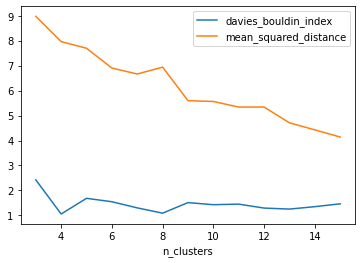

In [53]:
df.plot.line(x='n_clusters', y=['davies_bouldin_index', 'mean_squared_distance'])


So there's no perfect approach to determining the optimal number of clusters for a use case. I recommend taking the following approach when making the decision:

- Apply the elbo method, and see if it shows you a clear place where loss evens out
- Consider the DB index scores for the models
- Consider business rules or requirements that might affect how many clusters we can work with
- Choose the model that meets your business reuirements and has the best combination of low loss and low davies-bouldin score.

In the preceding graph, the orange line represents each model's loss, as represented by mean suare distance, charted against the number of clusters in the model. The trend of this line illustrates that increasing the number of clusters decreases loss, which is expected. The line also decreases steadily rather than hitting a point where loss evens out and creates an elbow shape. This indicates that for this data set, using the elbow method alone isnt sufficient to dtermine the optimal number of clusters

The blue line represents each models Davies-Bouldin score, charted against the number of clusters in the model. Since the elbo method didnt clearly identify the top performing model, you can alternatively identify that model by choosing one with a low DB index score.

The model with 12 clusters has failry low loss and the best DB score, so if business rules dont give you a reason to work with fewer clusters, it is the best choice. If business rules do give a reason to work with fewer cluster, the model with 4 clusters has the second best Davies-Bouldin score. For the sake of simplicity lets use model with 4 clusters

## Analyze the data clusters in the selected model

Here we will develop a understanding of how the data has been clustered in this model's centroids, and then analyze the data in each cluster to understand how many users are in it and what the clustering indicates about customer behavior


1. Use the ML.CENTROIDS SQL statement to get information about the centroids in each cluster for the ```gender``` feature 

In [54]:
model_to_use = 'kmeans_clusters_4' #Edit this to use a different model for analysis
final_model = 'kmeans.'+model_to_use

pd.set_option('max_colwidth', 400)

sql_get_attributes = f'''
SELECT
    centroid_id,
    feature,
    categorical_value
FROM
    ML.CENTROIDS(MODEL {final_model})
WHERE
    feature IN ('gender')
'''
job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(sql_get_attributes, job_config=job_config)
df_attributes = query_job.result()
df_attributes = df_attributes.to_dataframe()
df_attributes

,centroid_id,feature,categorical_value
0,1,gender,"[{'category': 'F', 'value': 0.4990953734815198}, {'category': 'M', 'value': 0.5009046265184802}]"
1,2,gender,"[{'category': 'F', 'value': 1.0}]"
2,3,gender,"[{'category': 'F', 'value': 0.4818181818181818}, {'category': 'M', 'value': 0.5181818181818182}]"
3,4,gender,"[{'category': 'F', 'value': 0.6153846153846154}, {'category': 'M', 'value': 0.38461538461538464}]"


Calculate summary statistics in the cluster data by using information from ML.PREDICT and ML.CENTROIDS

In [55]:
sql_get_numerical_attributes = f'''
WITH T AS (
SELECT
  centroid_id,
  ARRAY_AGG(STRUCT(feature AS name,
                   ROUND(numerical_value,1) AS value)
                   ORDER BY centroid_id)
                   AS cluster
FROM ML.CENTROIDS(MODEL {final_model})
GROUP BY centroid_id
),

Users AS(
SELECT
  centroid_id,
  COUNT(*) AS Total_Users
FROM(
SELECT
  * EXCEPT(nearest_centroids_distance)
FROM
  ML.PREDICT(MODEL {final_model},
    (
    SELECT
      *
    FROM
      {final_view.full_table_id.replace(":", ".")}
      )))
GROUP BY centroid_id
)

SELECT
  centroid_id,
  Total_Users,
  (SELECT value from unnest(cluster) WHERE name = 'Apparel') AS Apparel,
  (SELECT value from unnest(cluster) WHERE name = 'Office') AS Office,
  (SELECT value from unnest(cluster) WHERE name = 'Electronics') AS Electronics,
  (SELECT value from unnest(cluster) WHERE name = 'LimitedSupply') AS LimitedSupply,
  (SELECT value from unnest(cluster) WHERE name = 'Accessories') AS Accessories,
  (SELECT value from unnest(cluster) WHERE name = 'Bags') AS Bags,
  (SELECT value from unnest(cluster) WHERE name = 'ShopByBrand') AS ShopByBrand,
  (SELECT value from unnest(cluster) WHERE name = 'totalSpent_USD') AS totalSpent_USD,
  (SELECT value from unnest(cluster) WHERE name = 'hhi') AS HouseholdIncome

FROM T LEFT JOIN Users USING(centroid_id)
ORDER BY centroid_id ASC
'''

job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(sql_get_numerical_attributes, job_config=job_config)
df_numerical_attributes = query_job.result()
df_numerical_attributes = df_numerical_attributes.to_dataframe()
df_numerical_attributes.head()

,centroid_id,Total_Users,Apparel,Office,Electronics,LimitedSupply,Accessories,Bags,ShopByBrand,totalSpent_USD,HouseholdIncome
0,1,7700,2.300,0.800,0.600,0.500,0.400,0.300,0.300,183.700,74939.300
1,2,1,0.000,340.000,0.000,0.000,0.000,0.000,0.000,2022.900,75000.000
2,3,147,40.300,7.500,9.700,4.300,4.200,3.000,1.300,2368.700,74727.300
3,4,27,5.300,1.800,1.800,0.400,1.200,0.600,23.400,1002.900,76923.100


Considering both the centroid and summarized statistics data, you can determine the following characteristics for the model's clusters:

Cluster 1 — This is the most populated cluster. Customers in this cluster buy a lot in apparel. They purchase the most items, and have the second highest spending per item. They are not strongly brand motivated. The cluster skews slightly male.
Cluster 2 — This cluster is an outlier with only one person in it.
Cluster 3 — Customers in this cluster buy across all categories but buy most in apparel. They purchase fewer items than customers in Cluster 1, but spend significantly more per item. Thay are very likely to shop by brand. This cluster skews slightly more significantly male.
Cluster 4 — Customers in this cluster make small numbers of purchases and spend less on average. They are typically one time buyers rather than brand loyalists. Gender skew demonstrate more females fall into this cluster.